# Model with TCGNA data using sagemaker

The purpose of this notebook is to prototype an ML model using pytorch and deploying through Sagemaker. I'll based it on TCGNA, specifically from the following [paper](https://www.cell.com/cancer-cell/fulltext/S1535-6108(17)30053-3).

Disclaimer: I'm not a cancer expert and I'm doing this without guidance from one. My goal is to learn the infrastructure of these tools.

I'll be following using [this implementation](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_train.html) as a reference.

In [5]:
import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker
import seaborn as sns
import torch
import tqdm
from sagemaker.pytorch import PyTorch
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch import nn, optim

/Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[12/09/24 19:55:05] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=880952;file:///Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=302624;file:///Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/botocore/credentials.py#1278\1278]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/benlacar/Library/Application Support/sagemaker/config.yaml


In [6]:
%matplotlib inline
pd.set_option("display.max_columns", None)
rng = np.random.default_rng(12345)
sns.set_context("notebook")
sns.set_palette("colorblind")

In [7]:
DATA_DIR = "../data/"

In [13]:
sess = sagemaker.Session()
region = sess.boto_region_name

# get_execution_role()
role = "arn:aws:iam::545354767903:role/service-role/AmazonSageMaker-ExecutionRole-20241207T082397"  # noqa: E501
output_path = "s3://" + sess.default_bucket() + "/wandb_sdk"
print(output_path)

[12/09/24 20:02:44] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=641291;file:///Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=68732;file:///Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/botocore/credentials.py#1278\1278]8;;\

s3://sagemaker-us-west-2-545354767903/wandb_sdk


# Explore clinical data

In [14]:
df_clinical = pd.read_excel(
    Path(DATA_DIR, "Cherniack_s1_clinical_data.xlsx"), skiprows=1
)
print(df_clinical.shape)
df_clinical.head()

(57, 53)


/Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,bcr_patient_barcode,age_at_initial_pathologic_diagnosis,clinical_stage,primary_therapy_outcome_success,new_tumor_event_after_initial_treatment,days_to_new_tumor_event_after_initial_treatment,person_neoplasm_cancer_status,vital_status,DiseaseStatus,InferredTumorStatus,Prog/Recurrence,PFS,OS,days_to_death,days_to_last_followup,form_completion_date,height,weight,race,ethnicity,prior_malignancy,radiation_therapy,postoperative_rx_tx,histological_type,year_of_initial_pathologic_diagnosis,surgical_approach,peritoneal_wash,pct_tumor_invasion,total_pelv_lnr,pln_pos_light_micro,pln_pos_ihc,total_pelv_lnp,total_aor_lnr,aln_pos_light_micro,aln_pos_ihc,total_aor-lnp,patient_id,residual_tumor,system_version,tissue_source_site,Frozen % Sarc.,Frozen % Carc.,Frozen Poorly Diff %,Serous %,Endometroid %,Poorly DifferentiatedEpith %,Squamous %,UndifferentiatedSarc %,Leiomyosarcoma %,Heterologous cartilage %,Heterologous rhabdomyosarcoma %,Heterologous other (state) %,Histologic classification
0,TCGA-N5-A4R8,65,Stage IA,Complete Remission/Response,[Unknown],[Not Available],[Unknown],Dead,DOO,DiseaseFree,No,3115,3115,3115,[Not Available],2013-05-26,164,54,WHITE,NOT HISPANIC OR LATINO,No,YES,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2003,Minimally Invasive,negative,15,26,0,0,0,8,0,0,0,A4R8,R0,2009,N5,NaN,NaN,100.0,0,15,0,0,25,0,0,60,0,Serous-like
1,TCGA-N5-A4RA,63,Stage IIIC2,[Unknown],[Unknown],[Not Available],[Unknown],Dead,DOO?,Unknown,Missing,Missing,1591,1591,[Not Available],2013-05-26,152,72,WHITE,HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2004,open,negative,67,6,1,0,1,5,3,0,3,A4RA,RX,2009,N5,98.0,2.0,NaN,5,0,0,0,95,0,0,0,0,Serous-like
2,TCGA-N5-A4RD,69,Stage IVB,Progressive Disease,YES,75,WITH TUMOR,Dead,DOD,WithDisease,Yes,75,142,142,[Not Available],2013-05-26,159,59,WHITE,NOT HISPANIC OR LATINO,No,[Unknown],[Unknown],Uterine Carcinosarcoma/ MMMT: Heterologous Type,2007,open,positive,82,1,0,0,0,0,0,0,0,A4RD,R2,2009,N5,95.0,5.0,NaN,30,0,0,0,70,0,0,0,0,Serous-like
3,TCGA-N5-A4RF,68,Stage IA,Complete Remission/Response,NO,[Not Available],TUMOR FREE,Alive,NED,DiseaseFree,No,1439,1439,[Not Applicable],1439,2013-05-26,146,49,WHITE,[Not Evaluated],No,YES,YES,Uterine Carcinosarcoma/ MMMT: Homologous Type,2008,open,negative,28,32,0,0,0,9,0,0,0,A4RF,R0,2009,N5,98.0,2.0,NaN,0,40,0,0,60,0,0,0,0,Endometrioid-like
4,TCGA-N5-A4RJ,61,Stage IVB,Complete Remission/Response,YES,287,WITH TUMOR,Dead,DOD,WithDisease,Yes,287,550,550,[Not Available],2013-05-26,158,84,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2009,open,positive,6,0,0,0,0,3,3,0,3,A4RJ,RX,2009,N5,70.0,30.0,NaN,40,0,0,0,60,0,0,0,0,Serous-like


In [15]:
df_clinical["bcr_patient_barcode"].nunique()

57

## Identify a target and choose a feature to make a simple model

In [16]:
df_clinical["primary_therapy_outcome_success"].value_counts()

primary_therapy_outcome_success
Complete Remission/Response    27
Progressive Disease            13
[Not Available]                 8
Partial Remission/Response      4
[Unknown]                       3
[Not Applicable]                1
Stable Disease                  1
Name: count, dtype: int64

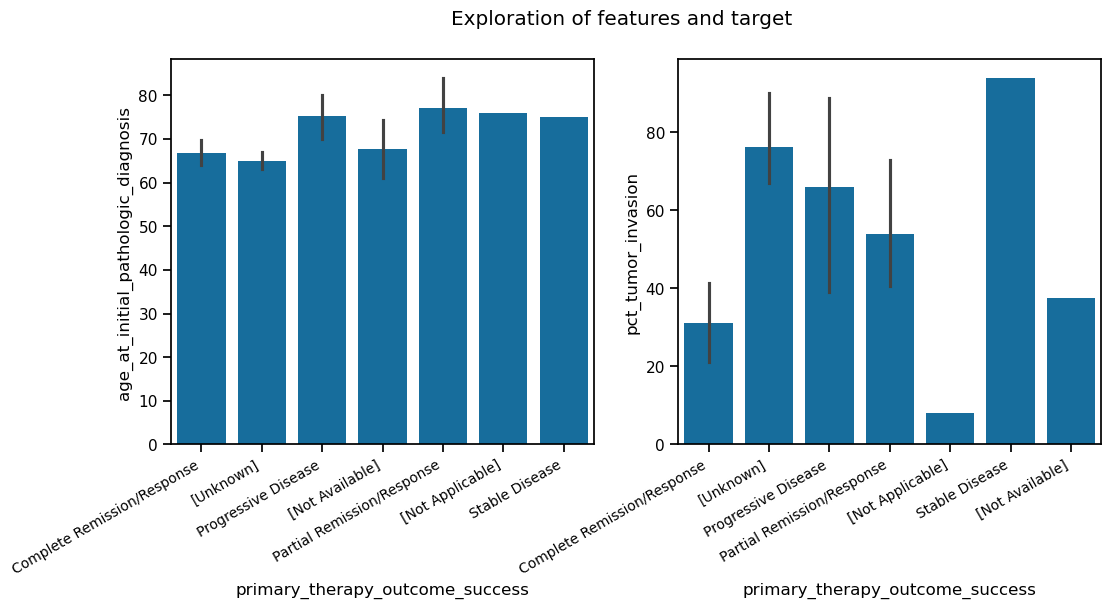

In [17]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    data=df_clinical,
    x="primary_therapy_outcome_success",
    y="age_at_initial_pathologic_diagnosis",
    ax=ax0,
)

xticks0 = ax0.get_xticks()
ax0.set_xticks(xticks0)
ax0.set_xticklabels(
    ax0.get_xticklabels(), rotation=30, horizontalalignment="right", fontsize=10
)

sns.barplot(
    data=df_clinical.query("pct_tumor_invasion != '[Not Available]'").astype(
        {"pct_tumor_invasion": float}
    ),
    x="primary_therapy_outcome_success",
    y="pct_tumor_invasion",
    ax=ax1,
)

xticks1 = ax1.get_xticks()
ax1.set_xticks(xticks1)
ax1.set_xticklabels(
    ax1.get_xticklabels(), rotation=30, horizontalalignment="right", fontsize=10
)

f.suptitle("Exploration of features and target");

In [18]:
# create a new column serving as a simpler binary target
targets_to_keep = [
    "Complete Remission/Response",
    "Progressive Disease",
    "Partial Remission/Response",
    "Stable Disease",
]

df_clinical_filtered = (
    df_clinical.query("primary_therapy_outcome_success in @targets_to_keep")
    .query("pct_tumor_invasion != '[Not Available]'")
    .astype({"pct_tumor_invasion": float})
    .set_index("bcr_patient_barcode")
    .copy()
)

# put the new column next to the old one
new_col_loc = (
    next(
        idx
        for idx, col in enumerate(df_clinical.columns)
        if col == "primary_therapy_outcome_success"
    )
    + 1
)

# make it a simple 0/1 classification with 1 being remission/response
df_clinical_filtered.insert(
    new_col_loc,
    "primary_therapy_outcome_success_binary",
    np.where(
        df_clinical_filtered["primary_therapy_outcome_success"]
        == "Complete Remission/Response",
        1,
        0,
    ),
)

print(df_clinical_filtered.shape)
df_clinical_filtered.head()

(40, 53)


,age_at_initial_pathologic_diagnosis,clinical_stage,primary_therapy_outcome_success,new_tumor_event_after_initial_treatment,primary_therapy_outcome_success_binary,days_to_new_tumor_event_after_initial_treatment,person_neoplasm_cancer_status,vital_status,DiseaseStatus,InferredTumorStatus,Prog/Recurrence,PFS,OS,days_to_death,days_to_last_followup,form_completion_date,height,weight,race,ethnicity,prior_malignancy,radiation_therapy,postoperative_rx_tx,histological_type,year_of_initial_pathologic_diagnosis,surgical_approach,peritoneal_wash,pct_tumor_invasion,total_pelv_lnr,pln_pos_light_micro,pln_pos_ihc,total_pelv_lnp,total_aor_lnr,aln_pos_light_micro,aln_pos_ihc,total_aor-lnp,patient_id,residual_tumor,system_version,tissue_source_site,Frozen % Sarc.,Frozen % Carc.,Frozen Poorly Diff %,Serous %,Endometroid %,Poorly DifferentiatedEpith %,Squamous %,UndifferentiatedSarc %,Leiomyosarcoma %,Heterologous cartilage %,Heterologous rhabdomyosarcoma %,Heterologous other (state) %,Histologic classification
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-N5-A4R8,65,Stage IA,Complete Remission/Response,[Unknown],1,[Not Available],[Unknown],Dead,DOO,DiseaseFree,No,3115,3115,3115,[Not Available],2013-05-26,164,54,WHITE,NOT HISPANIC OR LATINO,No,YES,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2003,Minimally Invasive,negative,15.0,26,0,0,0,8,0,0,0,A4R8,R0,2009,N5,NaN,NaN,100.0,0,15,0,0,25,0,0,60,0,Serous-like
TCGA-N5-A4RD,69,Stage IVB,Progressive Disease,YES,0,75,WITH TUMOR,Dead,DOD,WithDisease,Yes,75,142,142,[Not Available],2013-05-26,159,59,WHITE,NOT HISPANIC OR LATINO,No,[Unknown],[Unknown],Uterine Carcinosarcoma/ MMMT: Heterologous Type,2007,open,positive,82.0,1,0,0,0,0,0,0,0,A4RD,R2,2009,N5,95.0,5.0,NaN,30,0,0,0,70,0,0,0,0,Serous-like
TCGA-N5-A4RF,68,Stage IA,Complete Remission/Response,NO,1,[Not Available],TUMOR FREE,Alive,NED,DiseaseFree,No,1439,1439,[Not Applicable],1439,2013-05-26,146,49,WHITE,[Not Evaluated],No,YES,YES,Uterine Carcinosarcoma/ MMMT: Homologous Type,2008,open,negative,28.0,32,0,0,0,9,0,0,0,A4RF,R0,2009,N5,98.0,2.0,NaN,0,40,0,0,60,0,0,0,0,Endometrioid-like
TCGA-N5-A4RJ,61,Stage IVB,Complete Remission/Response,YES,1,287,WITH TUMOR,Dead,DOD,WithDisease,Yes,287,550,550,[Not Available],2013-05-26,158,84,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2009,open,positive,6.0,0,0,0,0,3,3,0,3,A4RJ,RX,2009,N5,70.0,30.0,NaN,40,0,0,0,60,0,0,0,0,Serous-like
TCGA-N5-A4RM,62,Stage IVB,Progressive Disease,YES,0,144,WITH TUMOR,Dead,DOD,WithDisease,Yes,144,148,148,[Not Available],2013-05-26,152,70,WHITE,NOT HISPANIC OR LATINO,No,NO,YES,Uterine Carcinosarcoma/ MMMT: Heterologous Type,2010,open,positive,40.0,18,0,0,0,3,0,0,0,A4RM,RX,2009,N5,90.0,10.0,NaN,0,20,0,0,80,0,0,0,0,Serous-like


In [19]:
# consider this as a feature to add later
df_clinical[["radiation_therapy", "primary_therapy_outcome_success"]].value_counts()

radiation_therapy  primary_therapy_outcome_success
YES                Complete Remission/Response        16
NO                 Complete Remission/Response        10
                   Progressive Disease                 9
                   [Not Available]                     4
YES                [Not Available]                     4
NO                 Partial Remission/Response          3
YES                Progressive Disease                 3
                   [Unknown]                           2
NO                 Stable Disease                      1
                   [Not Applicable]                    1
                   [Unknown]                           1
YES                Partial Remission/Response          1
[Unknown]          Complete Remission/Response         1
                   Progressive Disease                 1
Name: count, dtype: int64

# Additional data

In [20]:
df_mut_counts = pd.read_excel(
    Path(DATA_DIR, "Cherniack_s2_mutation_counts.xlsx"), skiprows=1
)
print(df_mut_counts.shape)
df_mut_counts.head(3)

(9149, 101)


/Users/benlacar/miniforge3/envs/wandb/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_file,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,Genome_Change,Annotation_Transcript,Transcript_Strand,Transcript_Exon,Transcript_Position,cDNA_Change,Codon_Change,Protein_Change,Other_Transcripts,Refseq_mRNA_Id,Refseq_prot_Id,SwissProt_acc_Id,SwissProt_entry_Id,Description,t_alt_count,t_ref_count,n_alt_count,n_ref_count,UniProt_AApos,UniProt_Region,UniProt_Site,UniProt_Natural_Variations,UniProt_Experimental_Info,GO_Biological_Process,GO_Cellular_Component,GO_Molecular_Function,COSMIC_overlapping_mutations,COSMIC_fusion_genes,COSMIC_tissue_types_affected,COSMIC_total_alterations_in_gene,Tumorscape_Amplification_Peaks,Tumorscape_Deletion_Peaks,TCGAscape_Amplification_Peaks,TCGAscape_Deletion_Peaks,DrugBank,ref_context,gc_content,CCLE_ONCOMAP_overlapping_mutations,CCLE_ONCOMAP_total_mutations_in_gene,CGC_Mutation_Type,CGC_Translocation_Partner,CGC_Tumor_Types_Somatic,CGC_Tumor_Types_Germline,CGC_Other_Diseases,DNARepairGenes_Role,FamilialCancerDatabase_Syndromes,MUTSIG_Published_Results,OREGANNO_ID,OREGANNO_Values,call_BCGSC,call_BCM,call_BI,call_WU,call_UCSC,validation_judgement_wes,validation_power_wes,validation_tumor_alt_count_wes,validation_tumor_ref_count_wes,validation_normal_alt_count_wes,validation_normal_ref_count_wes,validation_judgement_rna,validation_power_rna,validation_tumor_alt_count_rna,validation_tumor_ref_count_rna,validation_normal_alt_count_rna,validation_normal_ref_count_rna,num_Centers
0,AJAP1,55966,broad.mit.edu,37,1,4772258,4772258,+,Missense_Mutation,SNP,G,G,A,NaN,NaN,TCGA-N5-A4R8-01A-11D-A28R-08,TCGA-N5-A4R8-10A-01D-A28U-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Untested,Somatic,Phase_I,WXS,none,NaN,NaN,Illumina GAIIx,8a5cfe9c-405b-4e39-a4c1-a68ea61dfc6a,2204ecdd-1591-4ebf-ad83-6ec1fc3e9053,g.chr1:4772258G>A,ENST00000378191.4,+,2,709,c.328G>A,c.(328-330)Gcc>Acc,p.A110T,AJAP1_ENST00000378190.3_Missense_Mutation_p.A110T,NM_018836.3,NP_061324.1,Q9UKB5,AJAP1_HUMAN,adherens junctions associated protein 1,12,3,0,9,110.0,NaN,NaN,NaN,NaN,cell adhesion,adherens junction|apical plasma membrane|basol...,NaN,NaN,NaN,endometrium(4)|large_intestine(6)|lung(11)|ova...,24.0,all_cancers(77;0.071)|Ovarian(185;0.0721),all_cancers(23;1.77e-36)|all_epithelial(116;1....,NaN,Epithelial(90;3.89e-35)|OV - Ovarian serous cy...,NaN,CCAGGCGGCCGCCCTCGTGCC,0.736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0,1,0.999968,12,3,0,9,0.0,0.000000,0.0,0.0,0.0,9.0,2
1,HSPG2,3339,broad.mit.edu,37,1,22161313,22161313,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-N5-A4R8-01A-11D-A28R-08,TCGA-N5-A4R8-10A-01D-A28U-08,NaN,NaN,C,T,C,C,NaN,Valid,Somatic,Phase_I,WXS,RNA,NaN,NaN,Illumina GAIIx,8a5cfe9c-405b-4e39-a4c1-a68ea61dfc6a,2204ecdd-1591-4ebf-ad83-6ec1fc3e9053,g.chr1:22161313C>T,ENST00000374695.3,-,77,10658,c.10579G>A,c.(10579-10581)Ggg>Agg,p.G3527R,NaN,NM_005529.5,NP_005520.4,P98160,PGBM_HUMAN,heparan sulfate proteoglycan 2,35,41,0,54,3527.0,Ig-like C2-type 21.,NaN,NaN,NaN,angiogenesis|cell adhesion|lipid metabolic pro...,basement membrane|extracellular space|plasma m...,protein C-terminus binding,NaN,NaN,breast(6)|central_nervous_system(1)|cervix(1)|...,127.0,NaN,Colorectal(325;3.46e-05)|all_lung(284;7.93e-05...,NaN,UCEC - Uterine corpus endometrioid carcinoma (...,Becaplermin(DB00102)|Palifermin(DB00039),CGCAGGTGCCCTCCAACTTTG,0.637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1,1,1.000000,38,49,0,57,1.0,1.000000,14.0,39.0,0.0,57.0,4
2,ZMYM6,9204,broad.mit.edu,37,1,35476601,35476601,+,Missense_Mutation,SNP,

# Prototype a simple pytorch model using only age as a feature

Referenced: https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

In [21]:
df_clinical_filtered[
    [
        "primary_therapy_outcome_success_binary",
        "age_at_initial_pathologic_diagnosis",
        "pct_tumor_invasion",
    ]
].head()

,primary_therapy_outcome_success_binary,age_at_initial_pathologic_diagnosis,pct_tumor_invasion
bcr_patient_barcode,,,
TCGA-N5-A4R8,1,65,15.0
TCGA-N5-A4RD,0,69,82.0
TCGA-N5-A4RF,1,68,28.0
TCGA-N5-A4RJ,1,61,6.0
TCGA-N5-A4RM,0,62,40.0


array([[<Axes: title={'center': 'age_at_initial_pathologic_diagnosis'}>,
        <Axes: title={'center': 'pct_tumor_invasion'}>]], dtype=object)

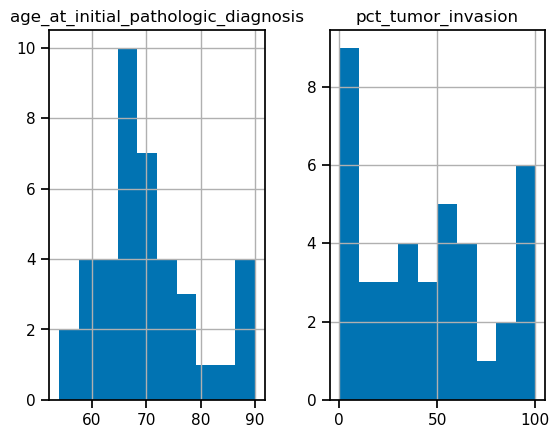

In [22]:
# check for normality
df_clinical_filtered[
    ["age_at_initial_pathologic_diagnosis", "pct_tumor_invasion"]
].hist()

In [23]:
X = df_clinical_filtered[["age_at_initial_pathologic_diagnosis", "pct_tumor_invasion"]]
X = torch.tensor(X.values, dtype=torch.float32)

y = df_clinical_filtered["primary_therapy_outcome_success_binary"]
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

In [24]:
n_features = X.shape[1]
n_labels = 2

In [25]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(in_features=n_features, out_features=n_labels)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [26]:
model_nn = SimpleNN()
print(
    f"No. of parameters: {sum([x.reshape(-1).shape[0] for x in model_nn.parameters()])}"
)

No. of parameters: 9


In [27]:
def model_train(  # noqa: PLR0913
    model, x_train, y_train, x_val, y_val, n_epochs, batch_size
):
    """
    `n_epochs` and `batch_size` will go to wandb config
    """

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    batch_start = torch.arange(0, len(x_train), batch_size)

    # Hold the best model
    best_acc = -np.inf  # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                x_batch = x_train[start : start + batch_size]
                y_batch = y_train[start : start + batch_size]
                # forward pass
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(loss=float(loss), acc=float(acc))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(x_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [28]:
# train-test split: Hold out the test set for final model evaluation
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 3-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True)
cv_scores_nn = []
for train, test in kfold.split(x_train, y_train):
    # create model, train, and get accuracy
    model = SimpleNN()
    acc = model_train(
        model,
        x_train[train],
        y_train[train],
        x_train[test],
        y_train[test],
        n_epochs=50,
        batch_size=5,
    )
    print("Accuracy (nn): %.2f" % acc)
    cv_scores_nn.append(acc)

# evaluate the model
nn_acc = np.mean(cv_scores_nn)
nn_std = np.std(cv_scores_nn)
print("nn: %.2f%% (+/- %.2f%%)" % (nn_acc * 100, nn_std * 100))

Accuracy (nn): 0.60
Accuracy (nn): 0.56
Accuracy (nn): 0.44
nn: 53.33% (+/- 6.54%)


In [29]:
model

SimpleNN(
  (hidden): Linear(in_features=2, out_features=2, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Sagemaker SDK implementation

from [here](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_train.html)

In [ ]:
# Set local_mode to True to run the training script on the
# machine that runs this notebook

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c4.xlarge"

est = PyTorch(
    entry_point="train.py",
    source_dir=".",  # directory of your training script
    role=role,
    framework_version="2.5.1",
    py_version="py3",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    hyperparameters={
        "batch-size": 128,
        "epochs": 1,
        "learning-rate": 1e-3,
        "log-interval": 100,
    },
)

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Dec 06 2024

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.30.0

pandas    : 2.2.3
seaborn   : 0.13.2
numpy     : 2.0.2
torch     : 2.5.1.post5
matplotlib: 3.9.2

Watermark: 2.5.0

